<h1 style="font-size:3rem;color:#A3623B;">Lab 3</h1>

## Security and Ethical aspects of data
### Amaya Nogales Gómez

## 3.1 Fairness metrics for synthetic datasets


In [1]:
# we import all the required libraries
import numpy as np
import matplotlib.pyplot as plt # for plotting stuff
from random import seed, shuffle
from scipy.stats import multivariate_normal # for generating synthetic data 
from sklearn import datasets #For real datasets
SEED = 1122334455
seed(SEED) # set the random seed so that the random permutations can be reproduced again
np.random.seed(SEED)

In [2]:
from sklearn.svm import SVC
from sklearn import metrics

def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

In [3]:
def generate_synthetic_data_bias():

    """
        Code for generating the synthetic data.
        We will have two features and a binary class.
        
    """

    n_samples = 20 # generate these many data points per class
    #For biased data
    p_sen=0.2 #this parameter sets the probability of being protected (sensitive feature=1)
    delta1=[3,-2] # This is the increment of the mean for the positive class
    delta2=[3,-2] # This is the increment of the mean for the negative class
    
    
    def gen_gaussian_sensitive(size, mean_in, cov_in, class_label, sensitive):
        nv = multivariate_normal(mean = mean_in, cov = cov_in)
        X = nv.rvs(size)
        y = np.ones(size, dtype=int) * class_label
        x_sen = np.ones(size, dtype=float) * sensitive
        return nv,X,y,x_sen

    """ Generate the features randomly """
    #For the NON-protected group (sensitive feature=0, for ex. men)
    # We will generate one gaussian cluster for each class
    mu1, sigma1 = [2, 2], [[5, 1], [1, 5]]
    mu2, sigma2 = [-2,-2], [[10, 1], [1, 3]]
    nv1, X1, y1, x_sen1= gen_gaussian_sensitive(int((1-p_sen)*n_samples), mu1, sigma1, 1,0) # positive class
    nv2, X2, y2, x_sen2= gen_gaussian_sensitive(int((1-p_sen)*n_samples),mu2, sigma2, 0,0) # negative class
    
    
    #For the Protected group (sensitive feature=1, for ex. women)
    # We will generate one gaussian cluster for each class
    mu3, sigma3 = np.add(mu1,delta1), [[5, 1], [1, 5]]
    mu4, sigma4 = np.add(mu2,delta2), [[10, 1], [1, 3]]
    nv3, X3, y3, x_sen3 = gen_gaussian_sensitive(int(p_sen*n_samples), mu3, sigma3, 1,1.) # positive class
    nv4, X4, y4, x_sen4 = gen_gaussian_sensitive(int(p_sen*n_samples),mu4, sigma4, 0,1.) # negative class
    

    

    # join the positive and negative class clusters
    X = np.vstack((X1, X2, X3, X4))
    y = np.hstack((y1, y2, y3, y4))
    x_prot= np.hstack((x_sen1, x_sen2, x_sen3, x_sen4))
    

    # shuffle the data
    perm = list(range(0,n_samples*2))
    shuffle(perm)
    X = X[perm]
    y = y[perm]
    x_prot=x_prot[perm]
    
    return X,y,x_prot

In [4]:
X_syn, y_syn, x_bias = generate_synthetic_data_bias()

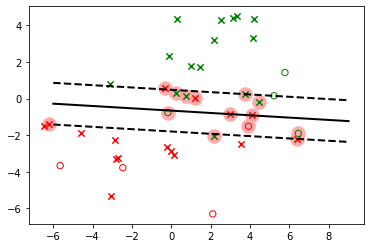

<Figure size 432x288 with 0 Axes>

In [5]:
#plt.scatter(X_syn[y_syn==1][:, 0], X_syn[y_syn==1][:, 1], color='#378661', marker='x', s=40, linewidth=1.5, label= "Class +1")
#plt.scatter(X_syn[y_syn==0][:, 0], X_syn[y_syn==0][:, 1], color='#A73730', marker='x', s=40, linewidth=1.5, label = "Class -1")

X_s_0 = X_syn[x_bias == 0.0]
X_s_1 = X_syn[x_bias == 1.0]
y_s_0 = y_syn[x_bias == 0.0]
y_s_1 = y_syn[x_bias == 1.0]

# SVM Classifier model
#the hyperparameter C control the margin violations
#smaller C leads to more margin violations but wider margin

svm_clf = SVC(kernel="linear", C=float(4))
svm_clf.fit(X_syn, y_syn)

plot_svc_decision_boundary(svm_clf, -6, 9)
plt.scatter(X_s_0[y_s_0==1][:, 0], X_s_0[y_s_0==1][:, 1], color='green', marker='x', s=40, linewidth=1.5, label= "Non-prot. +1")
plt.scatter(X_s_0[y_s_0==0][:, 0], X_s_0[y_s_0==0][:, 1], color='red', marker='x', s=40, linewidth=1.5, label = "Non-prot. -1")
plt.scatter(X_s_1[y_s_1==1][:, 0], X_s_1[y_s_1==1][:, 1], color='green', marker='o', facecolors='none', s=40, label = "Prot. +1")
plt.scatter(X_s_1[y_s_1==0][:, 0], X_s_1[y_s_1==0][:, 1], color='red', marker='o', facecolors='none', s=40, label = "Prot. -1")
plt.figure()
#plt.savefig('aggre.png')
plt.show()

First we calculate the accuracy of the SVM classifier in our dataset:

In [6]:
#Accuracy
y_pred=svm_clf.predict(X_syn)

print(f"Accuracy: {metrics.accuracy_score(y_syn, y_pred)*100} %")


Accuracy: 82.5 %


### Questions:

1- Without doing any calculation, does this classifier satisfy any of the fairness definitions studied in Lecture 3?\
Yes: fairness through unawerness (it doesn't see `x_bias`).

2-Calculate the equal opportunity metric for the given dataset and classifier.
See below.

In [36]:
f_eq_op = np.abs(y_pred[np.all([y_syn == 1, x_bias == 0], axis=0)].sum() / len(X_syn) - y_pred[np.all([y_syn == 1, x_bias == 1], axis=0)].sum() / len(X_syn)) # wrong
f_eq_op

0.325


3-Calculate the predictive equality metric for the given dataset and classifier.

4-Calculate the equalized odds metric for the given dataset and classifier.

5-Calculate the predictive parity metric for the given dataset and classifier.

6-Calculate the statistical parity metric for the given dataset and classifier.

7-a)Calculate the disparate impact metric for the given dataset and classifier.
  b)Does this classifier satisfy the 80%-rule?
  c)Formulate a sentence using the p value obtained in a). (Example: the ratio between ... and ... is of p%).


## 3.2 Fairness metrics for the German dataset

In [7]:
German_data = np.loadtxt('German.txt')
i_prot = 39  # the protected features corresponds with column 40 from the txt file
n_sample = 500  # we define our training sample size
C_param = 5

# We eliminate the first column that correspond to labels and the protected feature
X_German = np.delete(German_data, [0, i_prot], 1)

y_German = German_data[:, 0]  # labels
x_bias_german = German_data[:, i_prot]  # protected feature

# Now let us consider a training set
X_G = X_German[1:n_sample, :]
y_G = y_German[1:n_sample]
x_bias_G = x_bias_german[1:n_sample]


# SVM Classifier model
# the hyperparameter C control the margin violations
# smaller C leads to more margin violations but wider margin

svm_clf = SVC(kernel="linear", C=float(C_param))
svm_clf.fit(X_G, y_G)

y_pred_G = svm_clf.predict(X_G)

### Questions:
In the code before, we set i_prot=40, which means we consider the protected feature being "female divorced/separated/married". Under this choice:

1- Provide a table with the 6 fairness metrics.

2- Does this classifier satisfy the 80%-rule?

Now choose as protected feature being "male divorced/separated", i.e., i_prot=39. Under this choice:

3- Provide a table with the 6 fairness metrics.

4- Does this classifier satisfy the 80%-rule?

5- Can you obtain any conclusion comparing the tables from 1 and 3?